# 안전 운전자 예측 대회

포르투 세구로라는 브라질 보험회사에서 주최한 대회였음  
사고를 낼 가능성이 낮은 운전자에게 보험료를 적게 청구하고, 사고 가능성이 높은 난폭 운전자에게는 많은 보험료를 청구를 하도록 정확하게 예측하는 모델을 만드는게 대회 목표

주어진 데이터는 고객 데이터이고, 결측값은 -1로 되어있음  
타깃은 0:보험금 청구하지 않음, 1: 보험금 청구로 이진분류 문제이다

# EDA

## library 

In [16]:
import numpy as np 
import pandas as pd 
import matplotlib as mpl

import missingno as msno

import matplotlib.pyplot as plt 
%matplotlib inline 
plt.rcParams['font.family'] = 'Malgun Gothic'

import seaborn as sns 

## Load data

In [5]:
train = pd.read_csv('./train.csv', index_col = 'id')
train.head()

target  ps_ind_01  ps_ind_02_cat  ps_ind_03  ps_ind_04_cat  ps_ind_05_cat  \
id                                                                              
7        0          2              2          5              1              0   
9        0          1              1          7              0              0   
13       0          5              4          9              1              0   
16       0          0              1          2              0              0   
17       0          0              2          0              1              0   

    ps_ind_06_bin  ps_ind_07_bin  ps_ind_08_bin  ps_ind_09_bin  ...  \
id                                                              ...   
7               0              1              0              0  ...   
9               0              0              1              0  ...   
13              0              0              1              0  ...   
16              1              0              0              0  ...   
17              1              0              0              0  ...   

    ps_calc_11  ps_calc_12  ps_calc_13  ps_calc_14  ps_calc_15_bin  \
id                                                                   
7            9           1           5           8               0   
9            3           1           1           9               0   
13           4           2           7           7               0   
16           2           2           4           9               0   
17           3           1           1           3               0   

    ps_calc_16_bin  ps_calc_17_bin  ps_calc_18_bin  ps_calc_19_bin  \
id                                                                   
7                1               1               0               0   
9                1               1               0               1   
13               1               1               0               1   
16               0               0               0               0   
17               0               0               1               1   

    ps_calc_20_bin  
id                  
7                1  
9                0  
13               0  
16               0  
17               0  

[5 rows x 58 columns]

In [6]:
test = pd.read_csv('./test.csv', index_col = 'id')
test.head()

ps_ind_01  ps_ind_02_cat  ps_ind_03  ps_ind_04_cat  ps_ind_05_cat  \
id                                                                      
0           0              1          8              1              0   
1           4              2          5              1              0   
2           5              1          3              0              0   
3           0              1          6              0              0   
4           5              1          7              0              0   

    ps_ind_06_bin  ps_ind_07_bin  ps_ind_08_bin  ps_ind_09_bin  ps_ind_10_bin  \
id                                                                              
0               0              1              0              0              0   
1               0              0              0              1              0   
2               0              0              0              1              0   
3               1              0              0              0              0   
4               0              0              0              1              0   

    ...  ps_calc_11  ps_calc_12  ps_calc_13  ps_calc_14  ps_calc_15_bin  \
id  ...                                                                   
0   ...           1           1           1          12               0   
1   ...           2           0           3          10               0   
2   ...           4           0           2           4               0   
3   ...           5           1           0           5               1   
4   ...           4           0           0           4               0   

    ps_calc_16_bin  ps_calc_17_bin  ps_calc_18_bin  ps_calc_19_bin  \
id                                                                   
0                1               1               0               0   
1                0               1               1               0   
2                0               0               0               0   
3                0               1               0               0   
4                1               1               0               0   

    ps_calc_20_bin  
id                  
0                1  
1                1  
2                0  
3                0  
4                1  

[5 rows x 57 columns]

In [7]:
submission = pd.read_csv('./sample_submission.csv', index_col = 'id')
submission.head()

target
id        
0   0.0364
1   0.0364
2   0.0364
3   0.0364
4   0.0364

In [8]:
train.shape, test.shape

((595212, 58), (892816, 57))

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 595212 entries, 7 to 1488027
Data columns (total 58 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   target          595212 non-null  int64  
 1   ps_ind_01       595212 non-null  int64  
 2   ps_ind_02_cat   595212 non-null  int64  
 3   ps_ind_03       595212 non-null  int64  
 4   ps_ind_04_cat   595212 non-null  int64  
 5   ps_ind_05_cat   595212 non-null  int64  
 6   ps_ind_06_bin   595212 non-null  int64  
 7   ps_ind_07_bin   595212 non-null  int64  
 8   ps_ind_08_bin   595212 non-null  int64  
 9   ps_ind_09_bin   595212 non-null  int64  
 10  ps_ind_10_bin   595212 non-null  int64  
 11  ps_ind_11_bin   595212 non-null  int64  
 12  ps_ind_12_bin   595212 non-null  int64  
 13  ps_ind_13_bin   595212 non-null  int64  
 14  ps_ind_14       595212 non-null  int64  
 15  ps_ind_15       595212 non-null  int64  
 16  ps_ind_16_bin   595212 non-null  int64  
 17  ps_ind_17

결측이 없다고 나오지만, 실제로는 결측이 -1로 표시되어있기 때문에 없다고 나오는 것 $\rightarrow$ 1을 np.NaN으로 대체  
결측값을 시각화:높이가 낮을수록 결측이 많다는 의미 

<AxesSubplot:>

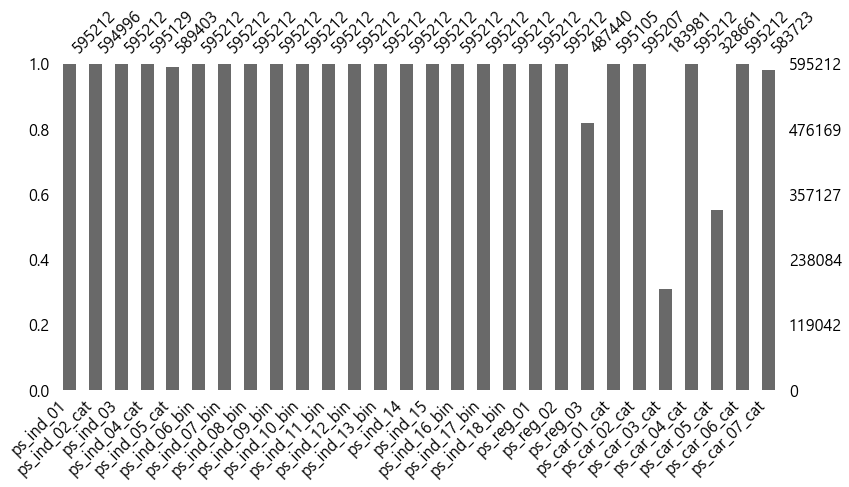

In [11]:
# train data를 복사gotj -1을 np.NaN으로 대체
train_copy = train.copy().replace(-1, np.NaN)

# 결측값 시각화(처음 28개만)
msno.bar(df = train_copy.iloc[:, 1:29], figsize = (13, 6))

<AxesSubplot:>

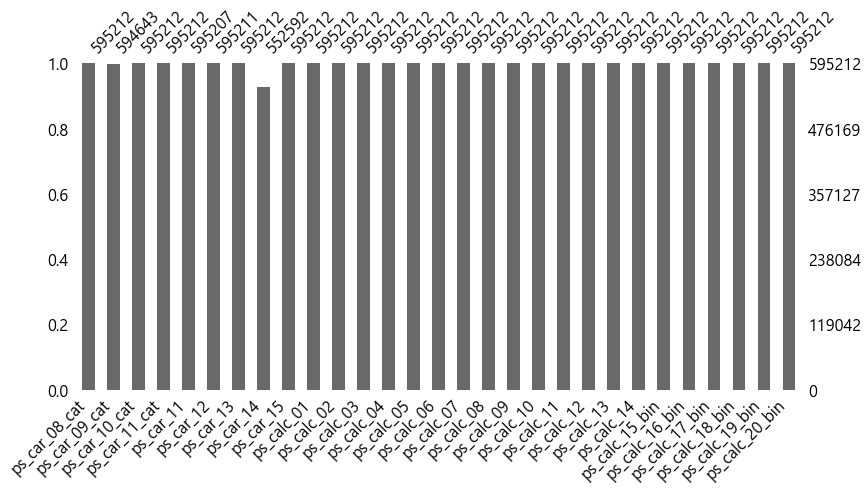

In [12]:
msno.bar(df = train_copy.iloc[:, 29:], figsize = (13, 6))

## 결측값 매트릭스 형태로 시각화

상대적인 분포를 보여줌  
검은색으로 뾰족하게 튀어나온 부분이 결측값이 몰려있는 행을 의미  
왼쪽에 표시된 22는 결측값이 없는 열의 개수, 28은 전체 열의 수

<AxesSubplot:>

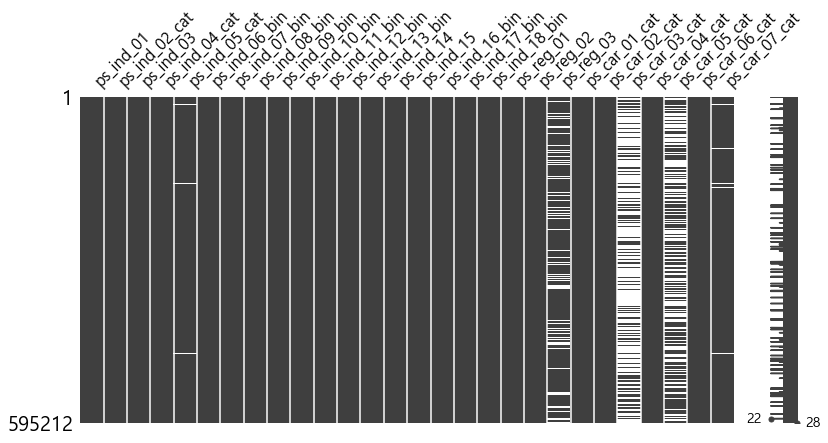

In [13]:
msno.matrix(df = train_copy.iloc[:, 1:29], figsize = (13, 6))

## 피쳐 요약표

In [14]:
def resumetable(df) : 
    print(f'dataset shape : {df.shape}')
    summary = pd.DataFrame(df.dtypes, columns = ['데이터 타입'])
    summary['결측값개수'] = (df == -1).sum().values
    summary['고유값개수'] = df.nunique().values
    summary['데이터종류'] = None
    for col in df.columns : 
        if 'bin' in col or col == 'target' : 
            summary.loc[col, '데이터종류'] = '이진형'
            
        elif 'cat' in col : 
            summary.loc[col, '데이터종류'] = '범주형'
            
        elif df[col].dtype == 'float64' : 
            summary.loc[col, '데이터종류'] = '연속형'
            
        elif df[col].dtype == 'int64' : 
            summary.loc[col, '데이터종류'] = '순서형'
    
    
    return summary

In [15]:
summary = resumetable(train)
summary

dataset shape : (595212, 58)


데이터 타입   결측값개수  고유값개수 데이터종류
target            int64       0      2   이진형
ps_ind_01         int64       0      8   순서형
ps_ind_02_cat     int64     216      5   범주형
ps_ind_03         int64       0     12   순서형
ps_ind_04_cat     int64      83      3   범주형
ps_ind_05_cat     int64    5809      8   범주형
ps_ind_06_bin     int64       0      2   이진형
ps_ind_07_bin     int64       0      2   이진형
ps_ind_08_bin     int64       0      2   이진형
ps_ind_09_bin     int64       0      2   이진형
ps_ind_10_bin     int64       0      2   이진형
ps_ind_11_bin     int64       0      2   이진형
ps_ind_12_bin     int64       0      2   이진형
ps_ind_13_bin     int64       0      2   이진형
ps_ind_14         int64       0      5   순서형
ps_ind_15         int64       0     14   순서형
ps_ind_16_bin     int64       0      2   이진형
ps_ind_17_bin     int64       0      2   이진형
ps_ind_18_bin     int64       0      2   이진형
ps_reg_01       float64       0     10   연속형
ps_reg_02       float64       0     19   연속형
ps_reg_03       float64  107772   5013   연속형
ps_car_01_cat     int64     107     13   범주형
ps_car_02_cat     int64       5      3   범주형
ps_car_03_cat     int64  411231      3   범주형
ps_car_04_cat     int64       0     10   범주형
ps_car_05_cat     int64  266551      3   범주형
ps_car_06_cat     int64       0     18   범주형
ps_car_07_cat     int64   11489      3   범주형
ps_car_08_cat     int64       0      2   범주형
ps_car_09_cat     int64     569      6   범주형
ps_car_10_cat     int64       0      3   범주형
ps_car_11_cat     int64       0    104   범주형
ps_car_11         int64       5      5   순서형
ps_car_12       float64       1    184   연속형
ps_car_13       float64       0  70482   연속형
ps_car_14       float64   42620    850   연속형
ps_car_15       float64       0     15   연속형
ps_calc_01      float64       0     10   연속형
ps_calc_02      float64       0     10   연속형
ps_calc_03      float64       0     10   연속형
ps_calc_04        int64       0      6   순서형
ps_calc_05        int64       0      7   순서형
ps_calc_06        int64       0     11   순서형
ps_calc_07        int64       0     10   순서형
ps_calc_08        int64       0     11   순서형
ps_calc_09        int64       0      8   순서형
ps_calc_10        int64       0     26   순서형
ps_calc_11        int64       0     20   순서형
ps_calc_12        int64       0     11   순서형
ps_calc_13        int64       0     14   순서형
ps_calc_14        int64       0     24   순서형
ps_calc_15_bin    int64       0      2   이진형
ps_calc_16_bin    int64       0      2   이진형
ps_calc_17_bin    int64       0      2   이진형
ps_calc_18_bin    int64       0      2   이진형
ps_calc_19_bin    int64       0      2   이진형
ps_calc_20_bin    int64       0      2   이진형

# 시각화

Text(0.5, 1.0, 'Target Distribution')

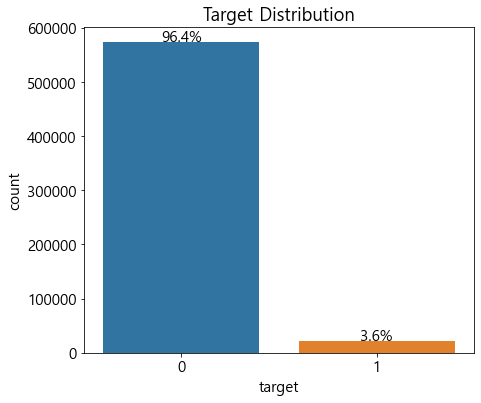

In [17]:
def write_percent(ax, total_size) : 
    for patch in ax.patches : 
        height = patch.get_height() 
        width = patch.get_width()
        left_coord = patch.get_x()
        percent = height / total_size * 100
        
        ax.text(left_coord + width/2,
                height + total_size * 0.001,
                '{:.1f}%'.format(percent),
                ha = 'center')
        
mpl.rc('font', size = 15)
plt.figure(figsize = (7, 6))

ax = sns.countplot(x = 'target', data = train)
write_percent(ax, len(train))
ax.set_title('Target Distribution')
        

운전자 중 3.6%만 보험금을 청구, 차 사고가 흔하게 나지는 않음  
타깃값이 불균형 $\rightarrow$ 비율이 작은 1을 잘 예측하는게 중요  
고윳값별 타깃값 1의 비율을 통해 모델링에 필요한 피처인지 확인

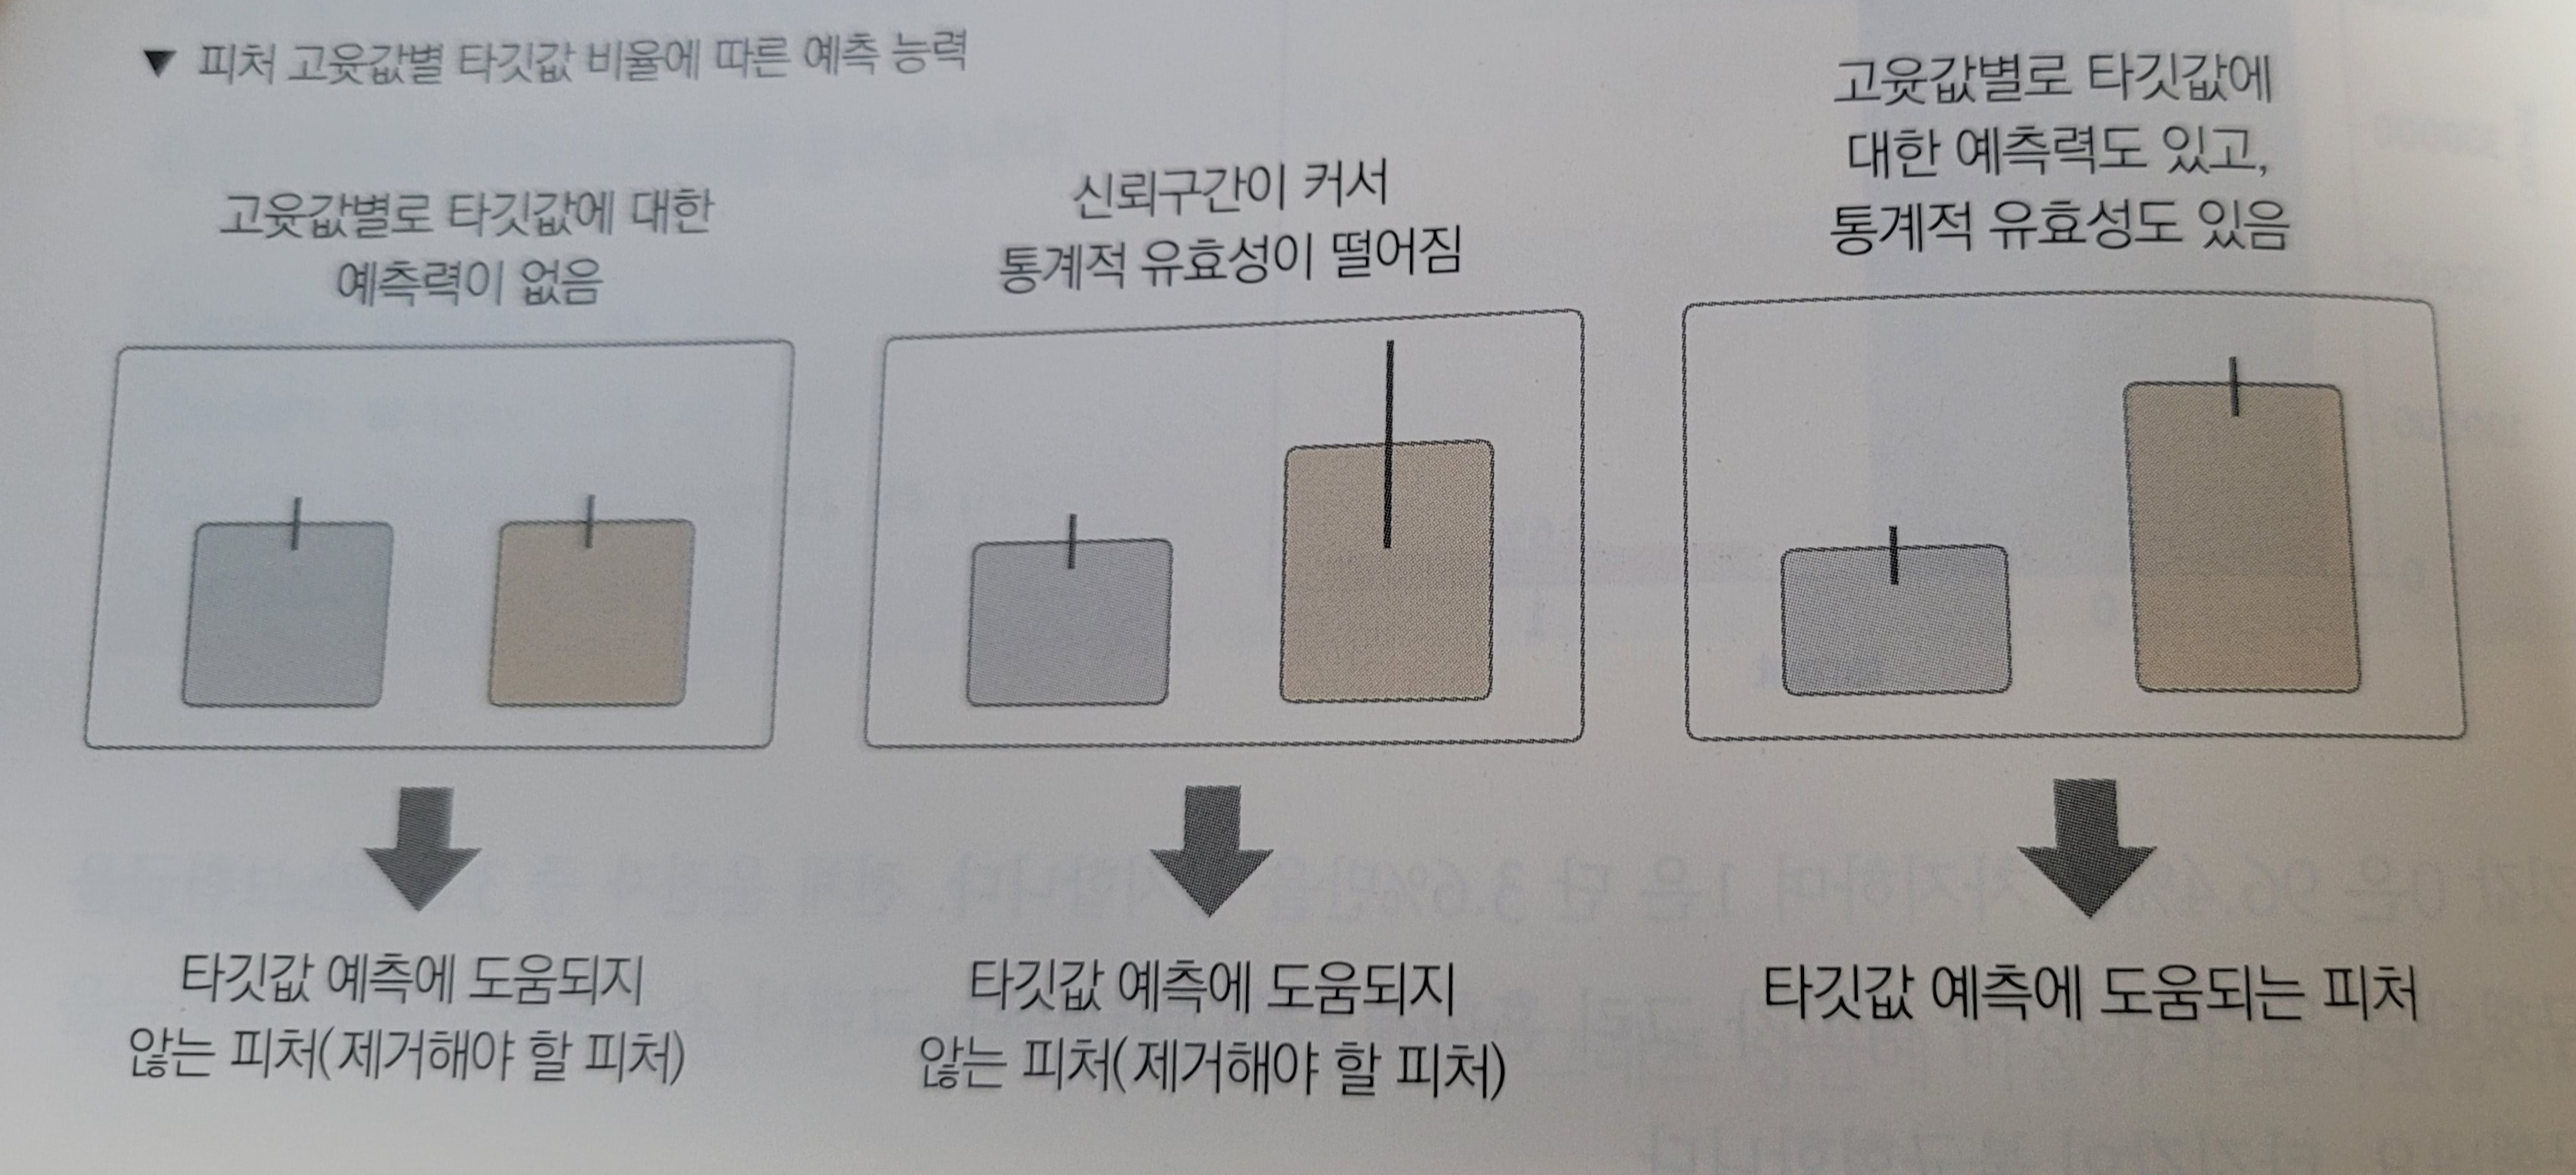

## 이진피처